Question 2 Math

In [194]:
import numpy as np
import math

# Define the origin and three vanishing points that were manually detected
origin = (1318, 1990)
u1,v1=(1657,159)
u2,v2=(745,3080)
u3,v3=(2876,3077)

# Compute A and b matrix
A=[[u1-u3, v1-v3],[u2-u3, v2-v3]]
b=[((u1-u3)*u2 + (v1-v3)*v2), ((u2-u3)*u1 + (v2-v3)*v1)]
print(A)
print(b)

# Solve "Ax=b"
x=np.linalg.lstsq(A,b)
print(x)

# Find principle point
x0, y0 = np.dot(np.linalg.inv(A), b)
print(x0, y0)

# Find focal point
focal_point = math.sqrt(-(u1-x0)*(u2-x0)-(v1-y0)*(v2-y0))
print(focal_point)


[[-1219, -2918], [-2131, 3]]
[-9895595, -3530590]
1660.5736987728053 2697.5173616161583
983.7005811985779


Question 3

In [195]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import cv2.aruco as aruco
import os


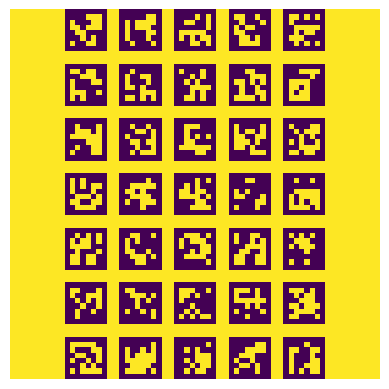

In [115]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_1000)

# Dimensions in cm
marker_length = 3.7
marker_separation = 1.1
aruco_params = aruco.DetectorParameters_create()
board = aruco.GridBoard_create(5,7,marker_length,marker_separation,aruco_dict)
imboard = board.draw((2000,2000))
cv2.imwrite("chessboard.png", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, interpolation="nearest")
ax.axis("off")
plt.show()

In [116]:
counter, corners_list, id_list = [],[],[]
first = 0
folder = "calibration_pics"

# Find aruco markers inside each image
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename))
    if img is not None:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        corners, ids, rejected = aruco.detectMarkers(
            img_gray,
            aruco_dict,
            parameters=aruco_params
        )
    if first:
        corners_list = np.vstack((corners_list, corners))
        id_list=np.vstack((id_list,ids))
    else:
        corners_list=corners
        id_list=ids
    first+=1
    counter.append(len(ids))

In [117]:
counter = np.array(counter)
ret, mtx, dist, rvecs,tvecs = aruco.calibrateCameraAruco(
    corners_list,
    id_list,
    counter,
    board,
    img_gray.shape,
    None,
    None
)

In [118]:
mtx

array([[5.79809819e+03, 0.00000000e+00, 1.02532172e+03],
       [0.00000000e+00, 5.72315054e+03, 1.24298224e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [119]:
dist

array([[  2.52683115, -13.31615208,  -0.16441339,  -0.01637706,
         14.82210046]])

Question 4

Use the pyAprilTag package to detect an AprilTag in an image (or use OpenCV for an Aruco Tag), for which you should take a photo of a tag. Use the K matrix you obtained above, to draw a 3D cube of the same size of the tag on the image, as if this virtual cube really is on top of the tag. Document the methods you use, and show your AR results from at least two different perspectives.


OpenCV's projectPoints, drawContours, addWeighted and line methods useful. You don't have to use all these methods.

In [120]:
# Setup Aruco variables
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
aruco_params = aruco.DetectorParameters_create()

# Still using previous board and imboard variables

In [231]:
# Load pictures from folder - will save finished pictures in current working directory
folder = os.path.join(os.getcwd(), "input_pics")

# Color coordinates
color = (0, 0, 255) # Red
line_thickness = 20
projection_z = 0.075 # How much to project cube upwards from aruco tag face

# Go to correct directory to output pictures
output_directory = os.path.join(os.getcwd(), "output_pics")
os.chdir(output_directory)

# Find aruco markers inside each image
for filename in os.listdir(folder):
    # Reset the variables for another file
    rvecs, tvecs, object_points = 0,0,0
    # This argument sometimes appears when looking for image files - remove file
    if (filename != ".DS_Store"): 
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            corners, ids, rejected = aruco.detectMarkers(
                img,
                aruco_dict,
                parameters=aruco_params
            )

            # estimatePoseSingleMarkers takes in 1) array of array of corners, 2) markerLength (use ruler, unit in m),
            #                                    3) cameraMatrix, and 4) distantCoefficients (from question 3)
            # estimatePoseSingleMarkers returns 1) rotation matrix, 2) translation matrix, 3) objectPoints
            rvecs, tvecs, object_points = aruco.estimatePoseSingleMarkers(corners, 0.075, mtx, dist)
            #print(object_points)
            new_object_points = np.copy(object_points)
            new_object_points = np.append(new_object_points, object_points)
            new_object_points = np.reshape(new_object_points, (8,3)) #reshape nparray to 8 rows of 3 columns of values

            # Edit the first four arrays in new_object_points s.t. the last index is z
            for ind, array in enumerate(new_object_points):
                if (ind < len(new_object_points)/2):
                    array[2] = projection_z
            # First half of new_object_points will have a z value of projection_z
            # The latter half will have a z value of 0

            #print(new_object_points)

            image_points, jacobian = cv2.projectPoints(new_object_points, rvecs, tvecs, mtx, dist)

            # Flatten image_points to easily pack values together with .reshape()
            image_points = np.ndarray.flatten(image_points)
            new_image_points = []
            for num in image_points:
                new_image_points.append(int(abs(num))) # Some of the values are negative
            new_image_points = np.reshape(new_image_points, (8,2))

            # Now join all the lines
            # Points 0-3: upper box
            # Points 4-7: lower box
            point0 = new_image_points[0]
            point1 = new_image_points[1]
            point2 = new_image_points[2]
            point3 = new_image_points[3]
            point4 = new_image_points[4]
            point5 = new_image_points[5]
            point6 = new_image_points[6]
            point7 = new_image_points[7]

            # Draw lines around upper box
            cv2.line(img, point0, point1, color, line_thickness)
            cv2.line(img, point1, point2, color, line_thickness)
            cv2.line(img, point2, point3, color, line_thickness)
            cv2.line(img, point3, point0, color, line_thickness)

            # Draw lines around lower box
            cv2.line(img, point4, point5, color, line_thickness)
            cv2.line(img, point5, point6, color, line_thickness)
            cv2.line(img, point6, point7, color, line_thickness)
            cv2.line(img, point7, point4, color, line_thickness)

            # Draw lines connecting lower and upper boxes
            cv2.line(img, point4, point0, color, line_thickness)
            cv2.line(img, point5, point1, color, line_thickness)
            cv2.line(img, point6, point2, color, line_thickness)
            cv2.line(img, point7, point3, color, line_thickness)

            # Write to image
            cv2.imwrite(filename, img=img)


[[[-0.0375  0.0375  0.    ]]

 [[ 0.0375  0.0375  0.    ]]

 [[ 0.0375 -0.0375  0.    ]]

 [[-0.0375 -0.0375  0.    ]]]
[[-0.0375  0.0375  0.08  ]
 [ 0.0375  0.0375  0.08  ]
 [ 0.0375 -0.0375  0.08  ]
 [-0.0375 -0.0375  0.08  ]
 [-0.0375  0.0375  0.    ]
 [ 0.0375  0.0375  0.    ]
 [ 0.0375 -0.0375  0.    ]
 [-0.0375 -0.0375  0.    ]]
[[[-0.0375  0.0375  0.    ]]

 [[ 0.0375  0.0375  0.    ]]

 [[ 0.0375 -0.0375  0.    ]]

 [[-0.0375 -0.0375  0.    ]]]
[[-0.0375  0.0375  0.08  ]
 [ 0.0375  0.0375  0.08  ]
 [ 0.0375 -0.0375  0.08  ]
 [-0.0375 -0.0375  0.08  ]
 [-0.0375  0.0375  0.    ]
 [ 0.0375  0.0375  0.    ]
 [ 0.0375 -0.0375  0.    ]
 [-0.0375 -0.0375  0.    ]]
[[[-0.0375  0.0375  0.    ]]

 [[ 0.0375  0.0375  0.    ]]

 [[ 0.0375 -0.0375  0.    ]]

 [[-0.0375 -0.0375  0.    ]]]
[[-0.0375  0.0375  0.08  ]
 [ 0.0375  0.0375  0.08  ]
 [ 0.0375 -0.0375  0.08  ]
 [-0.0375 -0.0375  0.08  ]
 [-0.0375  0.0375  0.    ]
 [ 0.0375  0.0375  0.    ]
 [ 0.0375 -0.0375  0.    ]
 [-0.0375 -0.0375